In [1]:
# импортируем необходимые модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# заданные типы в условии
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

# загрузка данных
train = pd.read_csv("data/train-001.csv", dtype=dtypes)
lectures = pd.read_csv("data/lectures.csv")
questions = pd.read_csv("data/questions.csv")

In [3]:
# размерность данных
print("Train size:", train.shape)
print("Lectures size:", lectures.shape)
print("Questions size:", questions.shape)

Train size: (101230332, 10)
Lectures size: (418, 4)
Questions size: (13523, 5)


In [4]:
# первые строки данных
print("Train:")
display(train.head())
print("Lectures:")
display(lectures.head())
print("Questions:")
display(questions.head())

Train:


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


Lectures:


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


Questions:


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [5]:
# приведение информации о просмотренном объяснении для облегчения подсчета
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('float32')
# базовая информация о данных
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 boolean
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  float32
dtypes: boolean(1), float32(2), int16(2), int32(1), int64(2), int8(2)
memory usage: 3.4 GB


In [6]:
# количество уникальных студентов
students_count = len(train['user_id'].unique())
print('Количество уникальных студентов:', students_count)

Количество уникальных студентов: 393656


In [7]:
print("Варианты ответов:", train['user_answer'].unique())
print("Варианты получения баллов:", train['answered_correctly'].unique())

Варианты ответов: [ 3  2  0  1 -1]
Варианты получения баллов: [ 1  0 -1]


In [8]:
# выборка только вопросов, без лекций
train_questions = train[train['content_type_id'] == 0]

In [9]:
# характеристики числовых данных в train.csv
train_questions.loc[:, ['timestamp', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']].describe()

,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
count,9.927130e+07,9.927130e+07,9.887879e+07,9.887879e+07
mean,7.702058e+09,6.572355e-01,2.542385e+04,9.070255e-01
std,1.159498e+10,4.746335e-01,1.994815e+04,2.903971e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.195280e+08,0.000000e+00,1.600000e+04,1.000000e+00
50%,2.669611e+09,1.000000e+00,2.100000e+04,1.000000e+00
75%,9.929147e+09,1.000000e+00,2.966600e+04,1.000000e+00
max,8.742577e+10,1.000000e+00,3.000000e+05,1.000000e+00


**В 91% случаев студенты пользовались объяснениями**

**В 66% случаев были получены правильные ответы**

In [10]:
# выбор столбцов с истинностью ответа и просмотра объяснения
(train_questions.loc[:, ['prior_question_had_explanation', 'answered_correctly']]
# группировка по объяснениям и подсчет среднего ответа
.groupby('prior_question_had_explanation').agg('mean'))

,answered_correctly
prior_question_had_explanation,
0.0,0.500629
1.0,0.673189


**Если студент получал пояснения, то отвечал правильно в 67% случаев, иначе только в 50%.**

Как часто студенты смотрели объяснения после ответа?

In [11]:
# df со смещенными столбцами объяснения и верного ответа
pd.DataFrame({
    'prior_question_had_explanation': train_questions['prior_question_had_explanation'][1:].reset_index(drop=True),
    'answered_correctly': train_questions['answered_correctly'][:-1].reset_index(drop=True)
}).groupby('answered_correctly').agg('mean')

,prior_question_had_explanation
answered_correctly,
0,0.864460
1,0.929161


**После правильного ответа студенты смотрели разъяснение чаще (93%), чем после неправильного (86%)**

Как зависит правильность ответа от времени ответа?

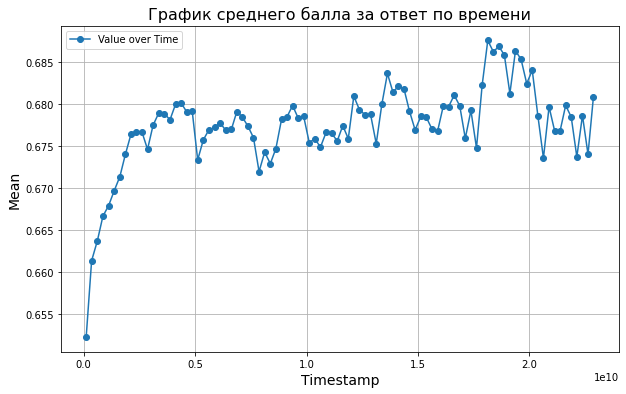

In [12]:
# удаление выбросов timestamp
train_temp = train_questions[(train_questions['timestamp'] < train_questions['timestamp'].quantile(0.9)) &
                             (train_questions['timestamp'] > train_questions['timestamp'].quantile(0.1))]
# группировка по времени и вычисление среднего балла для него
train_temp = train_temp[['timestamp', 'answered_correctly']].groupby(train_temp['timestamp'] // 250000000).mean().reset_index(level=0, drop=True)

# Настройка графика
plt.figure(figsize=(10, 6))
plt.plot(train_temp['timestamp'], train_temp['answered_correctly'], marker='o', label='Value over Time')

plt.title('График среднего балла за ответ по времени', fontsize=16)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Mean', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

**Чем ближе к концу тестирования давались ответы, тем больше среди них было правильных, хоть разброс значений и небольшой.**

Как зависит правильность ответа от полного времени обучения?

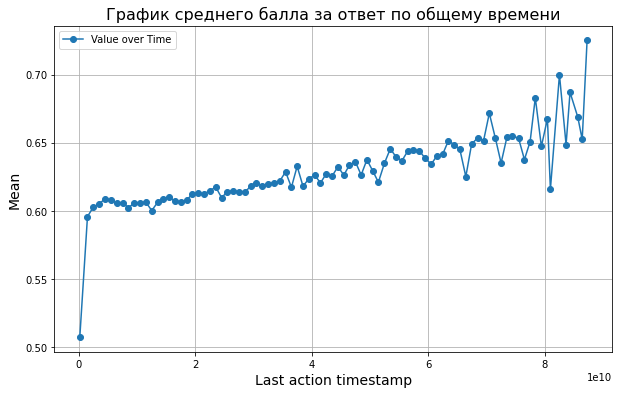

In [13]:
# группировка по пользователям и подсчет
# количества действий, времени последнего действия
# и среднего балла за задания
train_temp = train_questions.groupby('user_id').agg(
    actions_count = ('row_id', 'count'),
    last_action_time = ('timestamp', 'max'),
    mean_correct_ans = ('answered_correctly', 'mean')
)
# уборка выбросов по количеству дейсвий
train_temp = train_temp[train_temp['actions_count'] > train_temp['actions_count'].quantile(0.1)]
# группировка по времени последнего действия
train_temp = train_temp.groupby(train_temp['last_action_time'] // 1000000000)
# вычисление среднего балла за задания для участников группы
train_temp = train_temp.mean().reset_index(level=0, drop=True)

# Настройка графика
plt.figure(figsize=(10, 6))
plt.plot(train_temp['last_action_time'], train_temp['mean_correct_ans'], marker='o', label='Value over Time')


plt.title('График среднего балла за ответ по общему времени', fontsize=16)
plt.xlabel('Last action timestamp', fontsize=14)
plt.ylabel('Mean', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

**Можно заметить, что есть прямая зависимость количества правильных ответов от общего времени.**

Как влияет затраченное на вопрос время на количество правильных ответов?

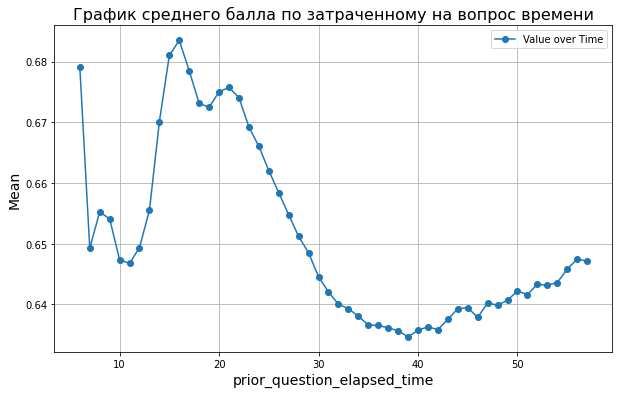

In [14]:
# удаление выбросов
train_temp = train_questions[train_questions['prior_question_elapsed_time'] < 
                             train_questions['prior_question_elapsed_time'].quantile(0.95)]
train_temp = train_temp[train_temp['prior_question_elapsed_time'] > 
                        train_temp['prior_question_elapsed_time'].quantile(0.05)]
# сдвиг строк
train_temp = pd.DataFrame({
    'prior_question_elapsed_time': train_temp['prior_question_elapsed_time'][1:],
    'answered_correctly': train_temp['answered_correctly'][:-1]
})
# группировка по времени с последнего вопроса и вычисление среднего балла
train_temp = train_temp.groupby(train_temp['prior_question_elapsed_time'] // 1000).mean().reset_index(level=0, drop=True)

# Настройка графика
plt.figure(figsize=(10, 6))
plt.plot(train_temp['prior_question_elapsed_time'] // 1000, train_temp['answered_correctly'], marker='o', label='Value over Time')

plt.title('График среднего балла по затраченному на вопрос времени', fontsize=16)
plt.xlabel('prior_question_elapsed_time', fontsize=14)
plt.ylabel('Mean', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

**Можно заметить, что правильные ответы чаще всего давались при затратах на вопрос от 15 до 25 секунд**

In [15]:
# добавляем данные из questions.csv
train_questions = pd.merge(train, questions, left_on='content_id', right_on='question_id', how='left')
# разбиваем теги по пробелу
train_questions['tags'] = train_questions['tags'].str.split()

In [16]:
# подсчет наиболее распространенных тегов
question_tags = train_questions['tags'].explode().value_counts()
print('Наиболее распространенные теги вопросов:')
question_tags.head(10)

Наиболее распространенные теги вопросов:


92     18991810
38     16880516
81     14052906
29     12516065
162     9758801
102     9030045
143     7256711
136     5203023
131     4561075
62      3366088
Name: tags, dtype: int64

Задачи с какими тегами студентам было легче/сложнее решать?

In [17]:
train_temp = train_questions[['answered_correctly', 'tags']]
train_temp = train_temp.explode('tags')
train_temp = train_temp.groupby('tags').mean().reset_index(level=0, drop=True).sort_values(by='answered_correctly')
train_temp

,answered_correctly
105,0.385725
99,0.436101
104,0.438487
76,0.485636
59,0.493155
...,...
181,0.809775
123,0.813804
98,0.819453
36,0.853152


**На вопросы с тегом 105 правильно ответили всего 38.6%, в то время как на вопросы с тегом 153 более 86%**

Какие темы были самыми легкими/сложными?

In [18]:
# выбор правильности ответов и темы
train_temp = train_questions[['answered_correctly', 'part']]
# группировка по темам и вычисление средних баллов
train_temp = train_temp.groupby('part').mean().reset_index(level=0, drop=True).sort_values(by='answered_correctly')
train_temp

,answered_correctly
4,0.598691
3,0.609149
6,0.651956
5,0.654881
2,0.686321
1,0.701912
0,0.722198


**На вопросы с темой 4 получены всего 60% правильных ответов, в то время как с темой 0 более 72%.**

Как зависит процент правильных ответов от количества просмотренных лекций?

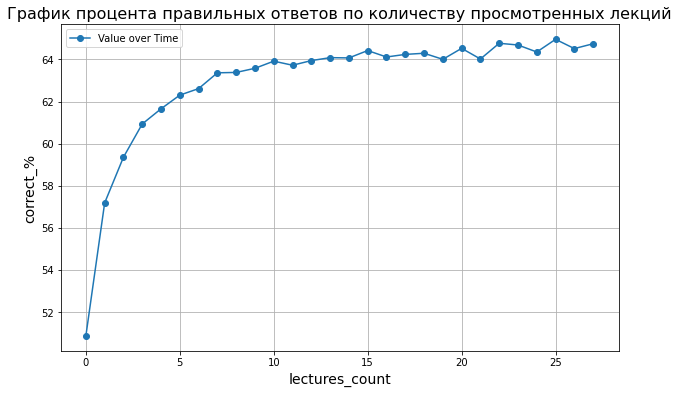

In [19]:
# группировка по пользователям, счет
# действий для пользователя, количества лекций,
# количества вопросов, количества правильных ответов
train_temp = train.groupby('user_id').agg(
    rows = ('row_id', 'count'),
    lectures = ('content_type_id', lambda x: len(x[x == 1])),
    questions = ('content_type_id', lambda x: len(x[x == 0])),
    correct = ('answered_correctly', lambda x: len(x[x == 1]))
)
# уборка выбросов по строкам и лекциям
train_temp = train_temp[(train_temp['rows'] > train_temp['rows'].quantile(0.1)) &
                       (train_temp['lectures'] < train_temp['lectures'].quantile(0.95))]
# вычисление процента правильных ответов
train_temp['correct_%'] = (train_temp['correct'] / train_temp['questions']) * 100
# группировка по количеству лекций и подсчет среднего процента правильных ответов
train_temp = train_temp[['lectures', 'correct_%']].groupby('lectures').mean().reset_index().sort_values(by='lectures')

# Настройка графика
plt.figure(figsize=(10, 6))
plt.plot(train_temp['lectures'], train_temp['correct_%'], marker='o', label='Value over Time')

plt.title('График процента правильных ответов по количеству просмотренных лекций', fontsize=16)
plt.xlabel('lectures_count', fontsize=14)
plt.ylabel('correct_%', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

**На графике видна прямая зависимость процента правильных ответов от количества просмотренных лекций**